# Kaplan-Meier Estimator

The Kaplan-Meier estimator is a non-parametric estimator of the survival function of lifetime data that can be used even in the presence of right-censoring.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="muted", color_codes=True)

from survive import datasets
from survive.univariate import KaplanMeier

## Example 1. Leukemia Remission Times

These data are the times of remission (in weeks) of leukemia patients in a control group and in a treatment group, taken from Table 1.1 of Cox and Oakes (1984). Due to the presence of right-censoring in the treatment group, each observation has a censoring indicator (the `Event` column), where `0` indicates right-censoring (i.e., the patent dropping out of the study) and `1` indicates a true event (i.e., remission).

In [2]:
leukemia = datasets.leukemia()

We can fit a Kaplan Meier estimator to the leukemia data using the `KaplanMeier` class in the `survive.univariate` module.

In [3]:
km_leukemia = KaplanMeier()
km_leukemia.fit("Time", status="Event", group="Group", data=leukemia)
print(km_leukemia.summary)

KaplanMeier(conf_type='log-log', conf_level=0.95)

Kaplan-Meier estimator

         observations  events  censored
Control            21      21         0

time  at risk  events  survival  std. err.  95% c.i. lower  95% c.i. upper
   1       21       2  0.904762   0.064056        0.670046        0.975294
   2       19       2  0.809524   0.085689        0.568905        0.923889
   3       17       1  0.761905   0.092943        0.519391        0.893257
   4       16       2  0.666667   0.102869        0.425350        0.825044
   5       14       2  0.571429   0.107990        0.337977        0.749241
   8       12       4  0.380952   0.105971        0.183067        0.577789
  11        8       2  0.285714   0.098581        0.116561        0.481820
  12        6       2  0.190476   0.085689        0.059482        0.377435
  15        4       1  0.142857   0.076360        0.035657        0.321162
  17        3       1  0.095238   0.064056        0.016259        0.261250
  22        2      

The survival curve estimates for the two groups can be compared by plotting.
Censored times are indicated by markers on the curve.

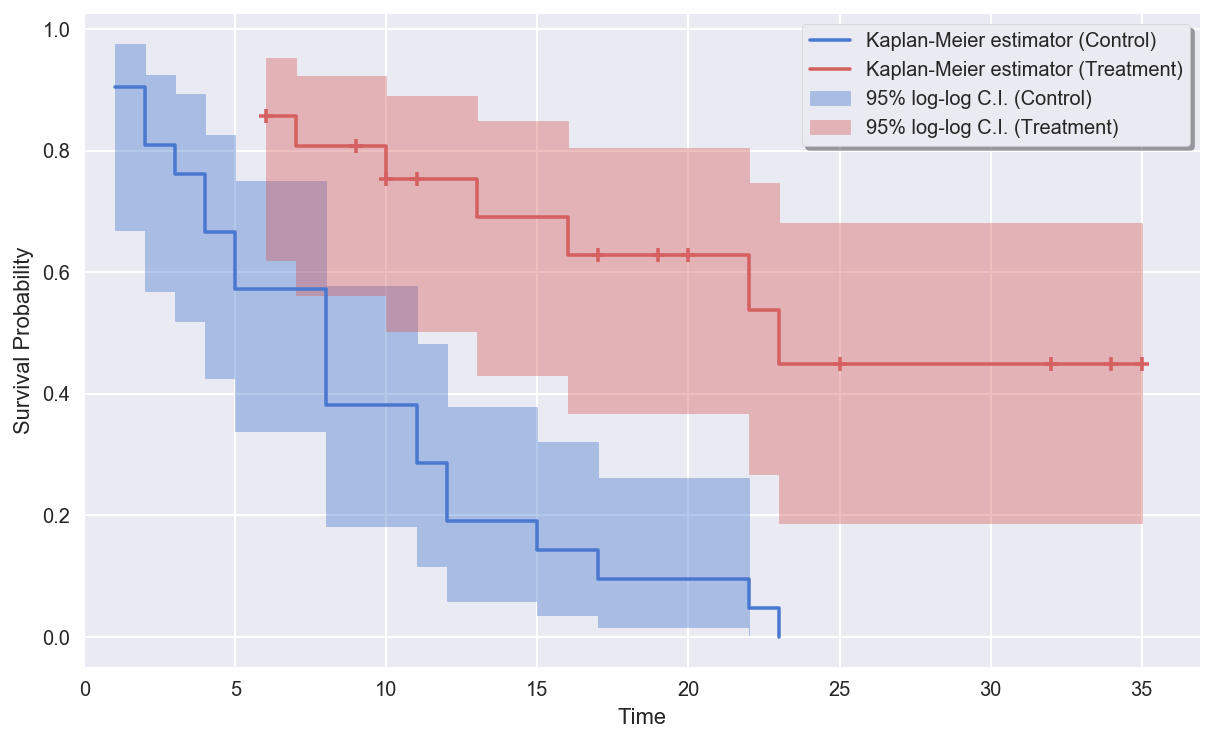

In [4]:
plt.figure(figsize=(10, 6))
km_leukemia.plot(color=("b", "r"))
plt.show()
plt.close()

## Example 2. Channing House Data

This is the `channing` dataset in the R package [`boot`](https://cran.r-project.org/web/packages/boot/index.html).
From the package description:
>Channing House is a retirement centre in Palo Alto, California.
>These data were collected between the opening of the house in 1964 until July 1, 1975.
>In that time 97 men and 365 women passed through the centre.
>For each of these, their age on entry and also on leaving or death was recorded.
>A large number of the observations were censored mainly due to the resident being alive on July 1, 1975 when the data was collected.
>Over the time of the study 130 women and 46 men died at Channing House.
>Differences between the survival of the sexes, taking age into account, was one of the primary concerns of this study.

In [5]:
channing = datasets.channing()
km_channing = KaplanMeier(conf_type="log")
km_channing.fit(channing.Exit, status=channing.Event, group=channing.Sex)

KaplanMeier(conf_type='log', conf_level=0.95)

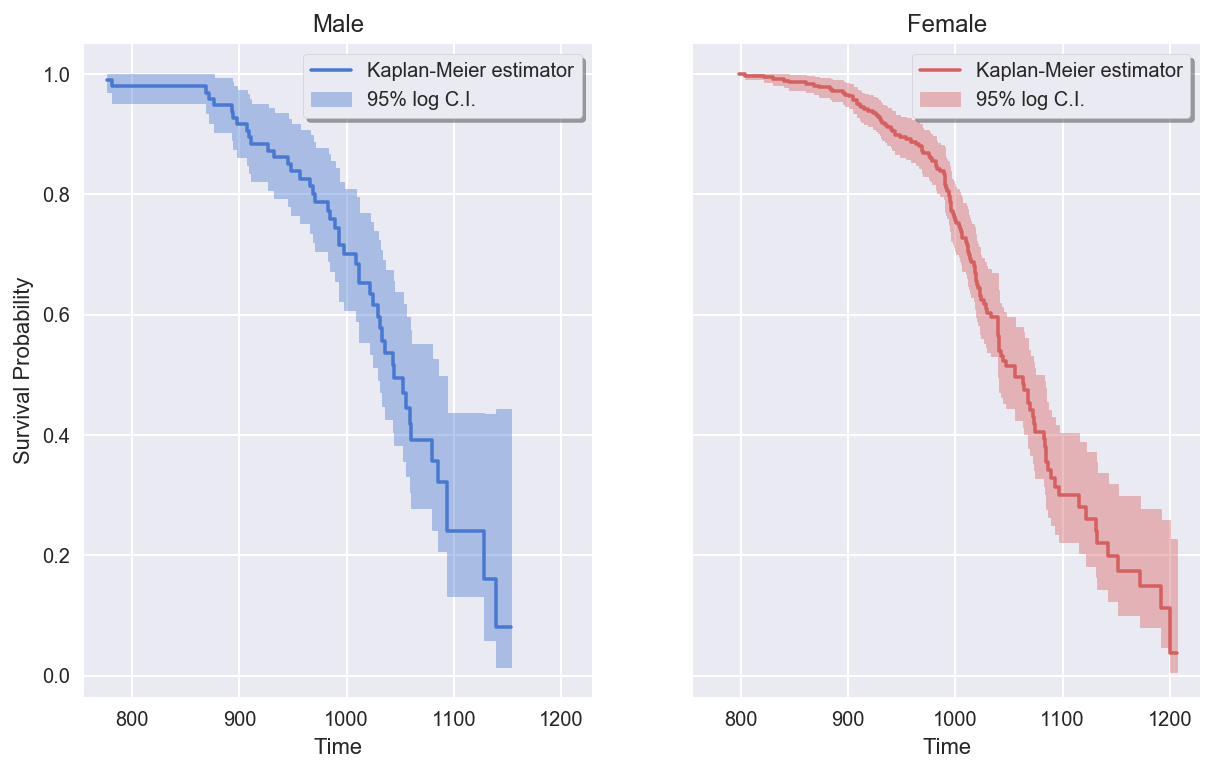

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex="all", sharey="all", figsize=(10, 6))
km_channing.plot("Male", mark_censor=False, color="b", ax=axes[0])
km_channing.plot("Female", mark_censor=False, color="r", ax=axes[1])
axes[0].set(title="Male")
axes[1].set(title="Female", ylabel="")
plt.show()
plt.close()

## Example 3. Simulated Gamma Data with Uniform Censoring

In [7]:
dist = st.gamma(a=3, scale=1)

# True failure times
true = dist.rvs(size=50, random_state=0)

# Random censoring times
censor = st.uniform.rvs(loc=0, scale=5, size=len(true), random_state=0)

# Observed times
observed = np.minimum(true, censor)

# Failure indicator (0=censor, 1=failure)
failure = observed == true

print(f"Proportion of censored data: {1 - np.mean(failure):.1%}")

Proportion of censored data: 52.0%


In [8]:
km = KaplanMeier(conf_type="plain")
km.fit(time=observed, status=failure)

KaplanMeier(conf_type='plain', conf_level=0.95)

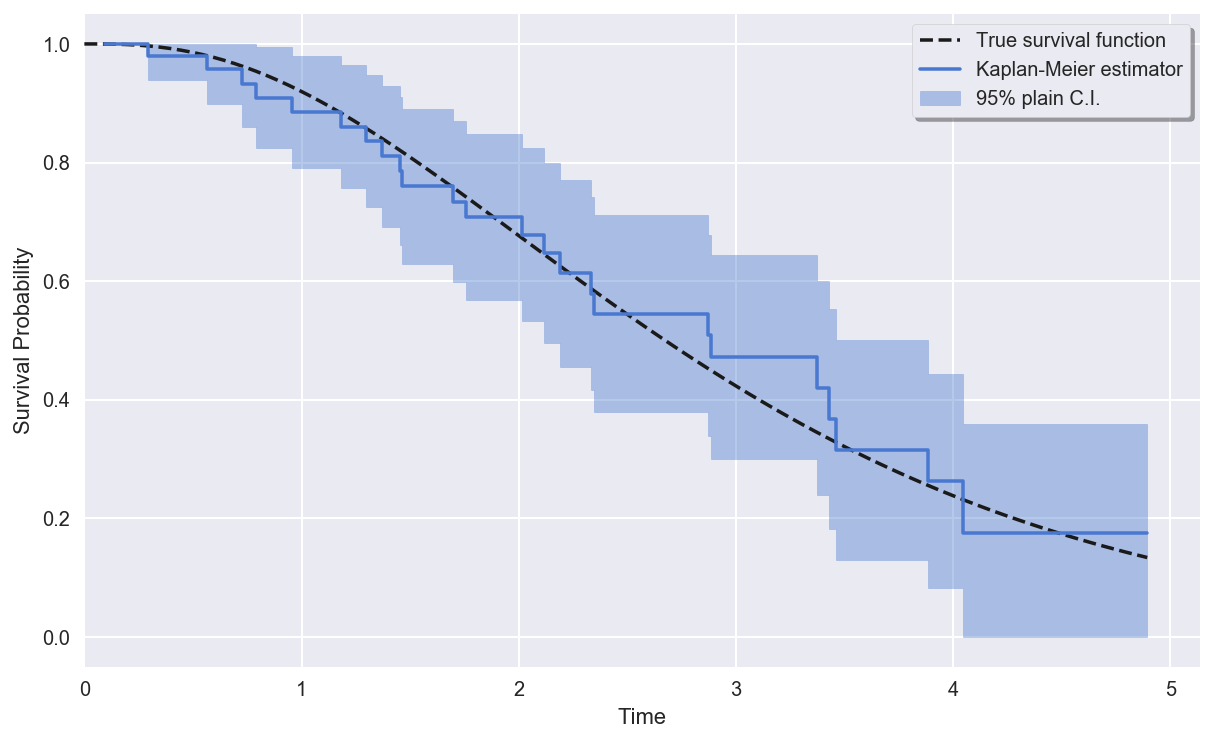

In [9]:
plt.figure(figsize=(10, 6))
x = np.linspace(0, max(observed), num=100)
y = 1 - dist.cdf(x)
plt.plot(x, y, ls="--", c="k", label="True survival function")
km.plot(mark_censor=False)
plt.show()
plt.close()

## References

* E. L. Kaplan and P. Meier.
  "Nonparametric estimation from incomplete observations".
  Journal of the American Statistical Association, Volume 53, Issue 282 (1958), pp. 457--481.
  ([DOI](https://doi.org/10.2307/2281868))
* D. R. Cox and D. Oakes.
  Analysis of Survival Data.
  Chapman & Hall, London (1984), pp. ix+201.